In [1]:
# sharpe ratio as reward function
def sharpe_ratio(rets):
    return rets.mean() / rets.std()

In [2]:
# try to find the position 
import numpy as np

def positions(x, theta):
    M = len(theta) - 2
    T = len(x)
    Ft = np.zeros(T)
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t - 1]]])
        Ft[t] = np.tanh(np.dot(theta, xt))
    return Ft

In [3]:
# calculate return
def returns(Ft, x, delta):
    T = len(x)
    rets = Ft[0:T - 1] * x[1:T] - delta * np.abs(Ft[1:T] - Ft[0:T - 1])
    return np.concatenate([[0], rets])

In [4]:
# determining the gradient
def gradient(x, theta, delta):
    Ft = positions(x, theta)
    rets = returns(Ft, x, delta)
    T = len(x)
    M = len(theta) - 2
    
    A = np.mean(rets)
    B = np.mean(np.square(rets))
    S = A / np.sqrt(B - A ** 2)

    grad = np.zeros(M + 2)  # initialize gradient
    dFpdtheta = np.zeros(M + 2)  # for storing previous dFdtheta
    
    for t in range(M, T):
        xt = np.concatenate([[1], x[t - M:t], [Ft[t-1]]])
        dRdF = -delta * np.sign(Ft[t] - Ft[t-1])
        dRdFp = x[t] + delta * np.sign(Ft[t] - Ft[t-1])
        dFdtheta = (1 - Ft[t] ** 2) * (xt + theta[-1] * dFpdtheta)
        dSdtheta = (dRdF * dFdtheta + dRdFp * dFpdtheta)
        grad = grad + dSdtheta
        dFpdtheta = dFdtheta

        
    return grad, S

In [5]:
# training
def train(x, epochs=500, M=5, commission=0.0025, learning_rate = 0.1):
    theta = np.ones(M + 2)
    sharpes = np.zeros(epochs) # store sharpes over time
    for i in range(epochs):
        grad, sharpe = gradient(x, theta, commission)
        theta = theta + grad * learning_rate
        sharpes[i] = sharpe
    
    print("finished training")
    return theta, sharpes

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 3) # (w, h)
plt.rcParams["figure.dpi"] = 150
import pandas as pd

btc = pd.read_csv("bitstampUSD.csv", names=["utc", "price", "volume"]).set_index('utc')
btc.index = pd.to_datetime(btc.index, unit='s')
rets = btc['price'].diff()[1:]

In [7]:
# train 1000 data, split data into train and test data
x = np.array(rets)

N = 1000
P = 200
x_train = x[-(N+P):-P]
x_test = x[-P:]

std = np.std(x_train)
mean = np.mean(x_train)

x_train = (x_train - mean) / std
x_test = (x_test - mean) / std

In [8]:
# training time
theta, sharpes = train(x_train, epochs=500, M=5, commission=0.0025, learning_rate=.001)

finished training


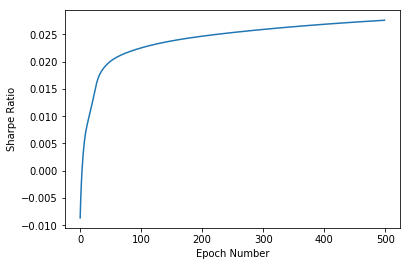

In [9]:
plt.plot(sharpes)
plt.xlabel('Epoch Number')
plt.ylabel('Sharpe Ratio');

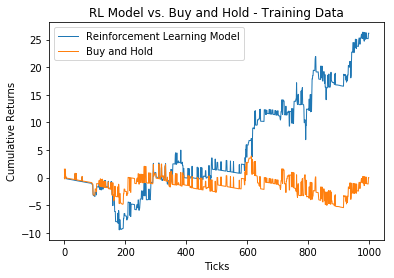

In [10]:
train_returns = returns(positions(x_train, theta), x_train, 0.0025)
plt.plot((train_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_train.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Training Data");

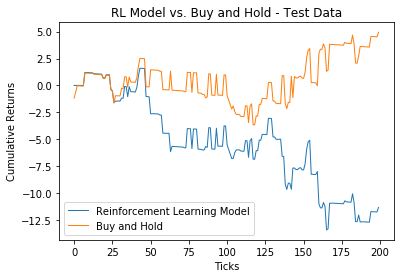

In [11]:
test_returns = returns(positions(x_test, theta), x_test, 0.0025)
plt.plot((test_returns).cumsum(), label="Reinforcement Learning Model", linewidth=1)
plt.plot(x_test.cumsum(), label="Buy and Hold", linewidth=1)
plt.xlabel('Ticks')
plt.ylabel('Cumulative Returns');
plt.legend()
plt.title("RL Model vs. Buy and Hold - Test Data");